In [45]:
!pip install transformers requests beautifulsoup4 pandas numpy

In [46]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

### Instantiate our model

In [47]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

### Encode and calculate sentiment

In [22]:
tokens = tokenizer.encode("this is good but it can be better", return_tensors="pt")

In [24]:
tokens

tensor([[  101, 10372, 10127, 12050, 10502, 10197, 10743, 10346, 16197,   102]])

In [25]:
result = model(tokens)

In [26]:
result.logits

tensor([[-1.9318, -0.2547,  1.7484,  1.1945, -0.7174]],
       grad_fn=<AddmmBackward0>)

In [27]:
int(torch.argmax(result.logits)) + 1

3

### Collect Reviews

In [28]:
r = requests.get('https://www.yelp.com/biz/mejico-sydney-2')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

In [29]:
r.text

'<!DOCTYPE html><html lang="en-US" prefix="og: http://ogp.me/ns#" style="margin: 0;padding: 0; border: 0; font-size: 100%; font: inherit; vertical-align: baseline;"><head><script>document.documentElement.className=document.documentElement.className.replace(/\x08no-js\x08/,"js");</script><meta http-equiv="Content-Type" content="text/html; charset=UTF-8" /><meta http-equiv="Content-Language" content="en-US" /><meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no"><link rel="mask-icon" sizes="any" href="https://s3-media0.fl.yelpcdn.com/assets/srv0/yelp_large_assets/b2bb2fb0ec9c/assets/img/logos/yelp_burst.svg" content="#FF1A1A"><link rel="shortcut icon" href="https://s3-media0.fl.yelpcdn.com/assets/srv0/yelp_large_assets/dcfe403147fc/assets/img/logos/favicon.ico"><script> window.ga=window.ga||function(){(ga.q=ga.q||[]).push(arguments)};ga.l=+new Date;window.ygaPageStartTime=new Date().getTime();</script><script>\n            window.yelp = window.yelp || {};\

In [31]:
results[0].text

"Seated without a booking on a super busy Saturday night. Lovely, warm, and Theo right hostess also looked after our table and went out of her way to give detailed ingredients in every dish to avoid allergies for one of us. And the food was great! Guacamole made right at our table, everything prepared with our allergies in mind, and great dish recommendations. We'd been visiting Sydney for about a week from Melbourne, and this was by far our best dining experience. I'd definitely return here in the future."

In [33]:
reviews[0]

"Seated without a booking on a super busy Saturday night. Lovely, warm, and Theo right hostess also looked after our table and went out of her way to give detailed ingredients in every dish to avoid allergies for one of us. And the food was great! Guacamole made right at our table, everything prepared with our allergies in mind, and great dish recommendations. We'd been visiting Sydney for about a week from Melbourne, and this was by far our best dining experience. I'd definitely return here in the future."

### Load reviews into DataFrame and Score

In [34]:
import pandas as pd
import numpy as np
df = pd.DataFrame(np.array(reviews), columns=['reviews'])

In [35]:
df.head()

,reviews
0,Seated without a booking on a super busy Satur...
1,The food was decent not great.. We had the gu...
2,"Food was okay, guacamole was below average. Se..."
3,The food and service here was really good. It...
4,Visiting from Texas and decided to give this r...


In [37]:
df['reviews'].iloc[0]

"Seated without a booking on a super busy Saturday night. Lovely, warm, and Theo right hostess also looked after our table and went out of her way to give detailed ingredients in every dish to avoid allergies for one of us. And the food was great! Guacamole made right at our table, everything prepared with our allergies in mind, and great dish recommendations. We'd been visiting Sydney for about a week from Melbourne, and this was by far our best dining experience. I'd definitely return here in the future."

In [38]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [40]:
 sentiment_score(df['reviews'].iloc[0])

5

our score for the first review is 5 which means it is a positive review

In [41]:
df['sentiment'] = df['reviews'].apply(lambda x: sentiment_score(x[:512]))

our NLP pipeline is only limited to 512 tokens so we only grabing the first 512 tokens for each one of these reviews.

In [42]:
df

,reviews,sentiment
0,Seated without a booking on a super busy Satur...,5
1,The food was decent not great.. We had the gu...,2
2,"Food was okay, guacamole was below average. Se...",2
3,The food and service here was really good. It...,5
4,Visiting from Texas and decided to give this r...,5
5,Don't come here expecting legit Mexican food b...,3
6,Out of all the restaurants that I tried in Syd...,5
7,"Great atmosphere, attentive service, solid mar...",3
8,We came here on a Thursday night @ 5pm and by ...,4
9,The food is fresh and tasty. The scallop cevi...,4


Text(0.5, 1.0, 'Distribution of Sentiment')

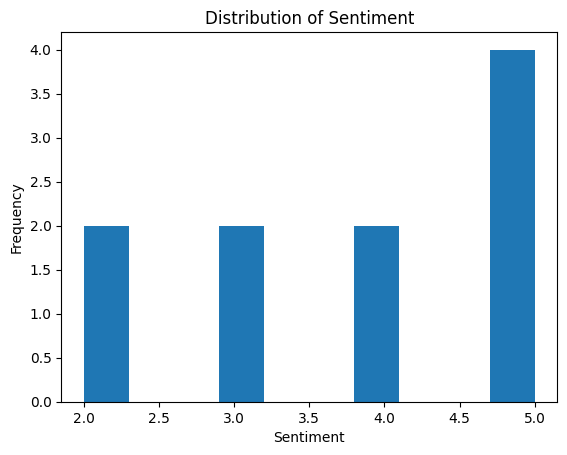

In [48]:
import matplotlib.pyplot as plt

plt.hist(df['sentiment'])
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment')